# Synthetic Example

### Imports

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

### System Configuration


In [2]:
seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

### Model Configuration

In [3]:
force = False

### Sampling Configuration

In [4]:
sigma = 3
num_steps = 1000
timestep = 0.01
num_samples = 512
temperature = 1200
kB = 8.6173303e-5 
std = np.sqrt(2 * kB * temperature * timestep)
log_prob = torch.distributions.Normal(0, std).log_prob
start_position = torch.tensor([-1.118, 0], dtype=torch.float32).to(device)
target_position = torch.tensor([1.118, 0], dtype=torch.float32).to(device)

### Training Configuration


In [5]:
log_z_lr = 0.001
policy_lr = 0.0001
batch_size = 512
num_rollouts = 10
max_grad_norm = 1
buffer_size = 10000
trains_per_rollout = 1000
start_temperature = 2400
end_temperature = 1200

temperatures = torch.linspace(
    start_temperature, end_temperature, num_rollouts
)
stds = torch.sqrt(2 * kB * timestep * temperatures)

### Synthetic System

In [6]:
def system(pos):
    pos.requires_grad_(True)
    x = pos[:, 0]
    y = pos[:, 1]
    term_1 = 4 * (1 - x**2 - y**2) ** 2
    term_2 = 2 * (x**2 - 2) ** 2
    term_3 = ((x + y) ** 2 - 1) ** 2
    term_4 = ((x - y) ** 2 - 1) ** 2
    potential = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0
    force = -torch.autograd.grad(potential.sum(), pos)[0]
    pos.requires_grad_(False)
    return force, potential.detach()

### Neural Bias Potential

In [7]:
class NeuralBiasPotential(nn.Module):
    def __init__(self):
        super().__init__()

        if force:
            self.output_dim = 2
        else:
            self.output_dim = 1

        self.input_dim = 3

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, self.output_dim, bias=False),
        )

        self.log_z = nn.Parameter(torch.tensor(0.0))

        self.to(device)

    def forward(self, pos):
        if not force:
            pos.requires_grad = True
            
        dist = torch.norm(pos - target_position, dim=-1, keepdim=True)
        pos_ = torch.cat([pos, dist], dim=-1)

        out = self.mlp(pos_.reshape(-1, self.input_dim))

        if not force:
            f = -torch.autograd.grad(
                out.sum(), pos, create_graph=True, retain_graph=True
            )[0]
        else:
            f = out.view(*pos.shape)

        return f

### TPS-DPS

In [8]:
class FlowNetAgent:
    def __init__(self):
        self.policy = NeuralBiasPotential()
        self.replay = ReplayBuffer()

    def sample(self, std):
        positions = torch.zeros(
            (num_samples, num_steps + 1, 2), device=device
        )
        forces = torch.zeros(
            (num_samples, num_steps + 1, 2),
            device=device,
        )
        noises = torch.normal(
            torch.zeros(
                (num_samples, num_steps, 2),
                device=device,
            ),
            torch.ones(
                (num_samples, num_steps, 2),
                device=device,
            ),
        )
        potentials = torch.zeros(num_samples, num_steps + 1, device=device)

        force, potential = system(start_position.unsqueeze(0))

        position = start_position.unsqueeze(0)

        forces[:, 0] = force
        positions[:, 0] = position
        potentials[:, 0] = potential


        for s in tqdm(range(num_steps), desc="Sampling"):
            bias = (
                self.policy(position.detach()).squeeze().detach()
            )
            position = position + (force + bias) * timestep + std * noises[:, s]
            force, potential = system(position)

            forces[:, s + 1] = force
            positions[:, s + 1] = position
            potentials[:, s + 1] = potential

        means = positions + forces * timestep
        log_running_reward = log_prob(positions[:, 1:] - means[:, :-1]).mean(
            (1, 2)
        )
        msd = (positions - target_position).square().mean(-1)
        log_target_reward = -0.5 / sigma**2 * msd
        log_target_reward, final_idx = log_target_reward.max(1)
        log_reward = log_running_reward + log_target_reward

        self.replay.add((positions, forces, log_reward))

        trunc_positions = []
        trunc_forces = []
        trunc_potentials = []
        

        for i in range(num_samples):
            trunc_positions.append(positions[i][: final_idx[i] + 1])
            trunc_forces.append(forces[i][: final_idx[i] + 1])
            trunc_potentials.append(potentials[i][: final_idx[i] + 1])
            
        return trunc_positions, trunc_forces, trunc_potentials

    def train(self):
        optimizer = torch.optim.Adam(
            [
                {"params": [self.policy.log_z], "lr": log_z_lr},
                {"params": self.policy.mlp.parameters(), "lr": policy_lr},
            ]
        )

        loss = 0
        for _ in tqdm(range(trains_per_rollout), desc="Training"):

            positions, forces, log_reward = self.replay.sample()
            biases = self.policy(positions)
            means = positions + (forces + biases) * timestep

            log_z = self.policy.log_z
            log_forward = log_prob(positions[:, 1:] - means[:, :-1]).mean((1, 2))
            tb_loss = (log_z + log_forward - log_reward).square().mean()
            tb_loss.backward()

            for group in optimizer.param_groups:
                torch.nn.utils.clip_grad_norm_(group["params"], max_grad_norm)

            optimizer.step()
            optimizer.zero_grad()

            loss += tb_loss.item()
        loss /= trains_per_rollout
        return loss
    
class ReplayBuffer:
    def __init__(self):
        self.positions = torch.zeros(
            (buffer_size, num_steps + 1, 2),
            device=device,
        )
        self.forces = torch.zeros(
            (buffer_size, num_steps + 1, 2),
            device=device,
        )
        self.log_reward = torch.zeros(buffer_size, device=device)

        self.idx = 0

    def add(self, data):
        indices = torch.arange(self.idx, self.idx + num_samples) % buffer_size
        self.idx += num_samples
        (
            self.positions[indices],
            self.forces[indices],
            self.log_reward[indices],
        ) = data

    def sample(self):
        indices = torch.randint(0, min(self.idx, buffer_size), (batch_size,))
        return (
            self.positions[indices],
            self.forces[indices],
            self.log_reward[indices],
        )

### Metrics and Plot

In [9]:
import torch

def print_metric(log):
    print(
        f"RMSD: {format_value(log['rmsd'], log['rmsd_std'])} & "
        f"THP: {format_value(log['thp'])} & "
        f"ETP: {format_value(log['etp'], log['etp_std'])} & "
        f"MinETP: {format_value(log['min_etp'])} & "
        f"EFP: {format_value(log['efp'], log['efp_std'])} & "
        f"LL: {format_value(log['ll'], log['ll_std'])} & "
        f"MaxLL: {format_value(log['max_ll'])}"
    )

def format_value(value, std_value=None):
    if value is None:
        return "-"
    if std_value is None:
        return f"{value:.2f}"
    return f"{value:.2f}±{std_value:.2f}"


class Metric:
    def __call__(self, positions, forces, potentials):
        final_position = torch.stack([position[-1] for position in positions])
        rmsd, rmsd_std = self.rmsd(final_position, target_position)
        thp, hit = self.thp(final_position, target_position)
        etp, etp_std, min_etp = self.etp(hit, potentials)
        efp, efp_std, min_efp = self.efp(hit, potentials)
        ll, ll_std, max_ll = self.ll(positions, forces)
        len, len_std = self.length(positions)

        metrics = {
            "rmsd": rmsd,
            "thp": thp,
            "etp": etp,
            "min_etp": min_etp,
            "efp": efp,
            "min_efp": min_efp,
            "ll": ll,
            "max_ll": max_ll,
            "len": len,
            "rmsd_std": rmsd_std,
            "etp_std": etp_std,
            "efp_std": efp_std,
            "ll_std": ll_std,
            "len_std": len_std,
        }
        self.paths(positions[:16])
        return metrics

    def rmsd(self, final_position, target_position):
        rmsd = (final_position - target_position).square().sum(-1).sqrt()
        mean_rmsd, std_rmsd = rmsd.mean().item(), rmsd.std().item()
        return mean_rmsd, std_rmsd

    def thp(self, final_position, target_position):
        hit = (final_position - target_position).square().sum(-1).sqrt() < 0.5
        thp = 100 * hit.sum().float() / len(hit)
        return thp.item(), hit

    def etp(self, hit, potentials):
        etps = []
        for i, hit_idx in enumerate(hit):
            if hit_idx:
                etp = potentials[i].max(0)[0]
                etps.append(etp)

        if len(etps) > 0:
            etps = torch.tensor(etps)
            mean_etp, std_etp = etps.mean().item(), etps.std().item()
            min_etp = etps.min().item()
            return mean_etp, std_etp, min_etp
        else:
            return None, None, None

    def efp(self, hit, potentials):
        efps = []
        for i, hit_idx in enumerate(hit):
            if hit_idx:
                efp = potentials[i][-1]
                efps.append(efp)

        if len(efps) > 0:
            efps = torch.tensor(efps)
            mean_efp, std_efp = efps.mean().item(), efps.std().item()
            min_efp = efps.min().item()
            return mean_efp, std_efp, min_efp
        else:
            return None, None, None

    def ll(self, positions, forces):
        lls = []
        for i in range(num_samples):
            mean = positions[i] + forces[i] * timestep
            ll = log_prob(positions[i][1:] - mean[:-1]).mean(0).sum()
            lls.append(ll)
        lls = torch.tensor(lls)
        mean_ll, std_ll = lls.mean().item(), lls.std().item()
        max_ll = lls.max().item()
        return mean_ll, std_ll, max_ll

    def length(self, positions):
        lengths = []
        for i in range(num_samples):
            length = positions[i].shape[0]
            lengths.append(length)
        lengths = torch.tensor(lengths, dtype=torch.float)
        mean_len, std_len = lengths.mean().item(), lengths.std().item()
        return mean_len, std_len
    

    def paths(self, positions):
        ax = plt.subplots(figsize=(7, 7))[1]

        zorder = 100
        circle_size = 1200
        saddle_size = 2400

        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        x = np.linspace(-1.5, 1.5, 400)
        y = np.linspace(-1.5, 1.5, 400)
        X, Y = np.meshgrid(x, y)

        term_1 = 4 * (1 - X**2 - Y**2) ** 2
        term_2 = 2 * (X**2 - 2) ** 2
        term_3 = ((X + Y) ** 2 - 1) ** 2
        term_4 = ((X - Y) ** 2 - 1) ** 2
        Z = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0

        ax.contourf(X, Y, Z, levels=zorder, zorder=0, vmax=3)

        cm = plt.get_cmap("gist_rainbow")

        ax.set_prop_cycle(
            color=[cm(1.0 * i / len(positions)) for i in range(len(positions))]
        )

        for position in positions:
            xs = position[:, 0].detach().cpu().numpy()
            ys = position[:, 1].detach().cpu().numpy()
            ax.plot(
                xs,
                ys,
                marker="o",
                linestyle="None",
                markersize=2,
                alpha=1.0,
                zorder=zorder - 1,
            )

        # Plot start and end positions
        ax.scatter(
            [start_position[0].item()],
            [start_position[1].item()],
            edgecolors="black",
            c="w",
            zorder=zorder,
            s=circle_size,
        )
        ax.scatter(
            [target_position[0].item()],
            [target_position[1].item()],
            edgecolors="black",
            c="w",
            zorder=zorder,
            s=circle_size,
        )

        saddle_points = [(0, 1), (0, -1)]
        for saddle in saddle_points:
            ax.scatter(
                saddle[0],
                saddle[1],
                edgecolors="black",
                c="w",
                zorder=zorder,
                s=saddle_size,
                marker="*",
            )

        # Plot basic configs
        ax.set_xlabel("x", fontsize=24, fontweight="medium")
        ax.set_ylabel("y", fontsize=24, fontweight="medium")
        plt.tick_params(
            left=False,
            right=False,
            labelleft=False,
            labelbottom=False,
            bottom=False,
        )
        plt.tight_layout()
        plt.show()
        plt.close()


### Training

Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 416.61it/s]


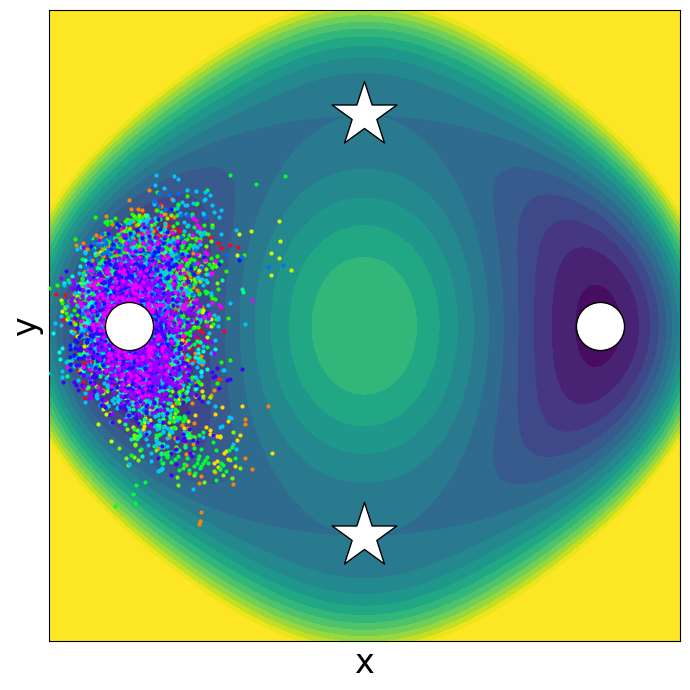

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.55it/s]


Rollout: 0, Loss: 0.000496
RMSD: 1.66±0.30 & THP: 2.54 & ETP: 1.82±0.27 & MinETP: 1.42 & EFP: -0.04±0.14 & LL: 2.33±0.11 & MaxLL: 2.72


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.96it/s]


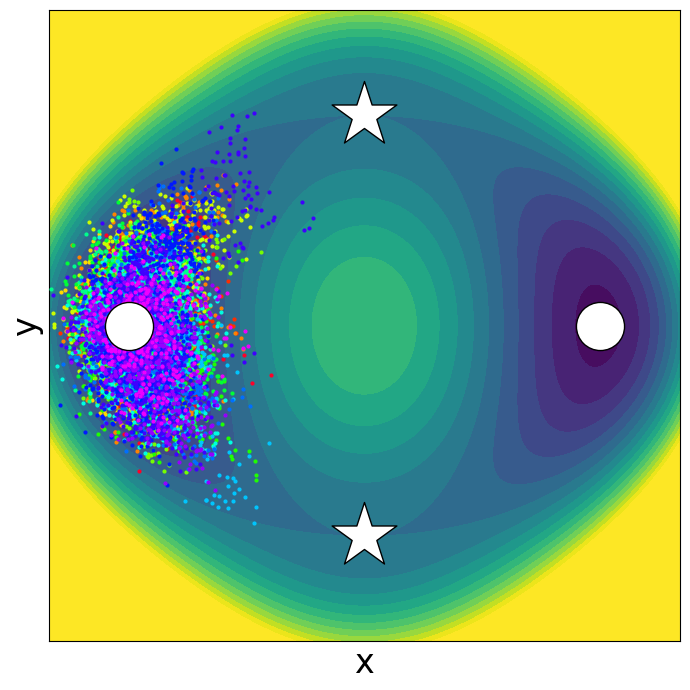

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.55it/s]


Rollout: 1, Loss: 0.000285
RMSD: 1.64±0.28 & THP: 2.34 & ETP: 1.79±0.28 & MinETP: 1.54 & EFP: -0.06±0.05 & LL: 2.42±0.12 & MaxLL: 2.70


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 551.77it/s]


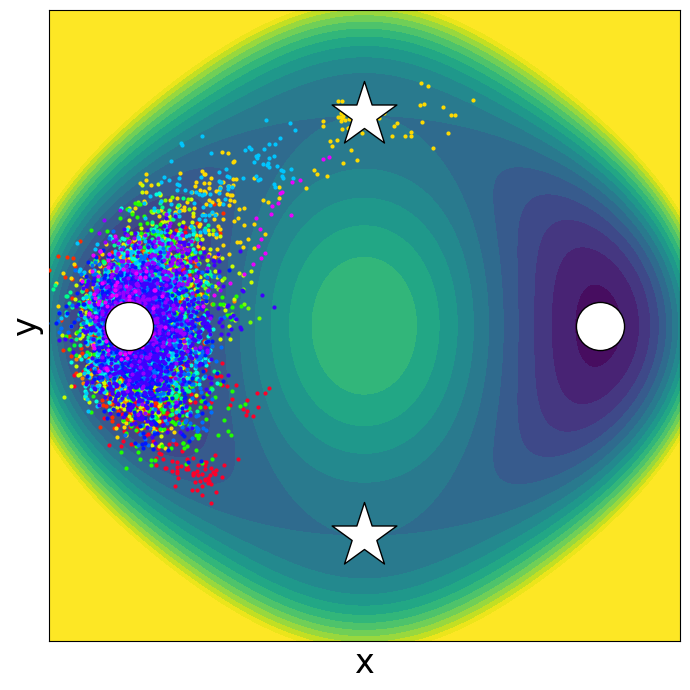

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.98it/s]


Rollout: 2, Loss: 0.000390
RMSD: 1.53±0.50 & THP: 8.98 & ETP: 1.62±0.25 & MinETP: 1.25 & EFP: -0.08±0.01 & LL: 2.54±0.12 & MaxLL: 2.84


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.46it/s]


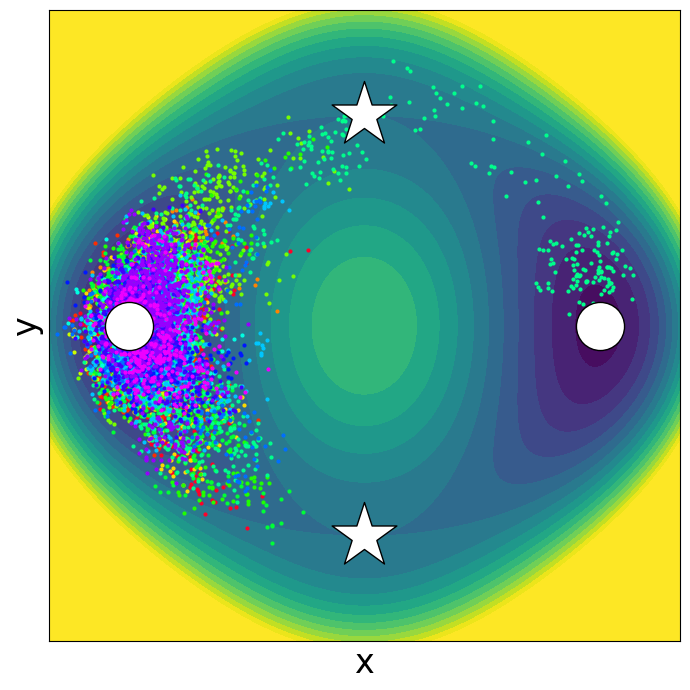

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.99it/s]


Rollout: 3, Loss: 0.000517
RMSD: 1.25±0.67 & THP: 21.68 & ETP: 1.58±0.24 & MinETP: 1.12 & EFP: -0.07±0.06 & LL: 2.65±0.10 & MaxLL: 2.95


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.81it/s]


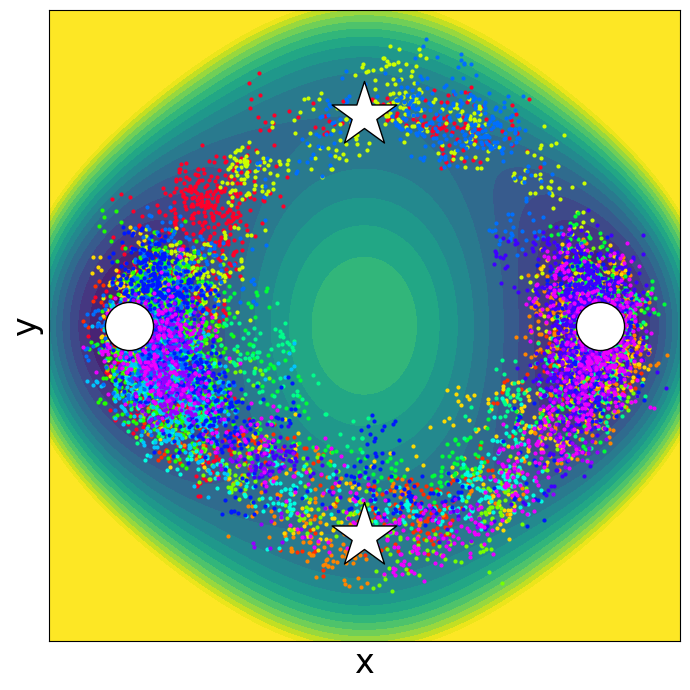

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.03it/s]


Rollout: 4, Loss: 0.000591
RMSD: 0.32±0.60 & THP: 78.32 & ETP: 1.57±0.24 & MinETP: 1.15 & EFP: -0.08±0.03 & LL: 2.75±0.06 & MaxLL: 2.95


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 511.60it/s]


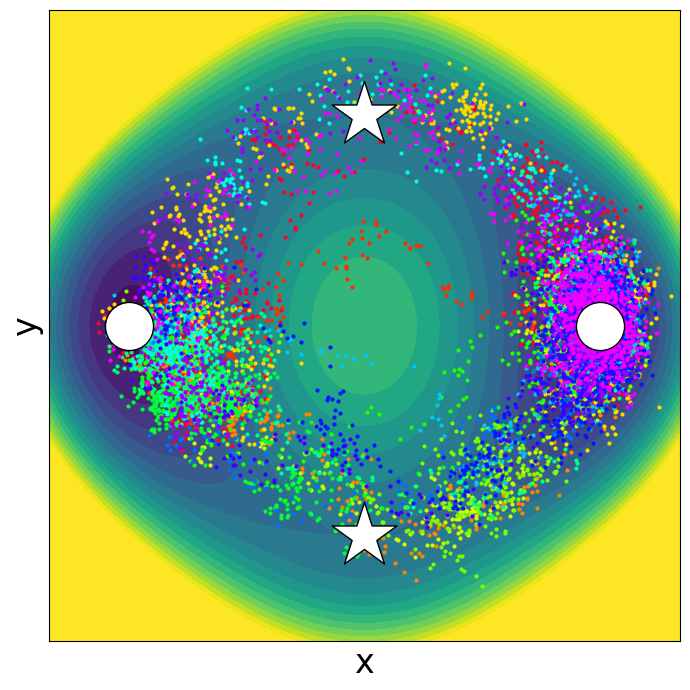

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.29it/s]


Rollout: 5, Loss: 0.000363
RMSD: 0.01±0.03 & THP: 99.80 & ETP: 1.56±0.24 & MinETP: 1.10 & EFP: -0.08±0.00 & LL: 2.86±0.06 & MaxLL: 3.03


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.91it/s]


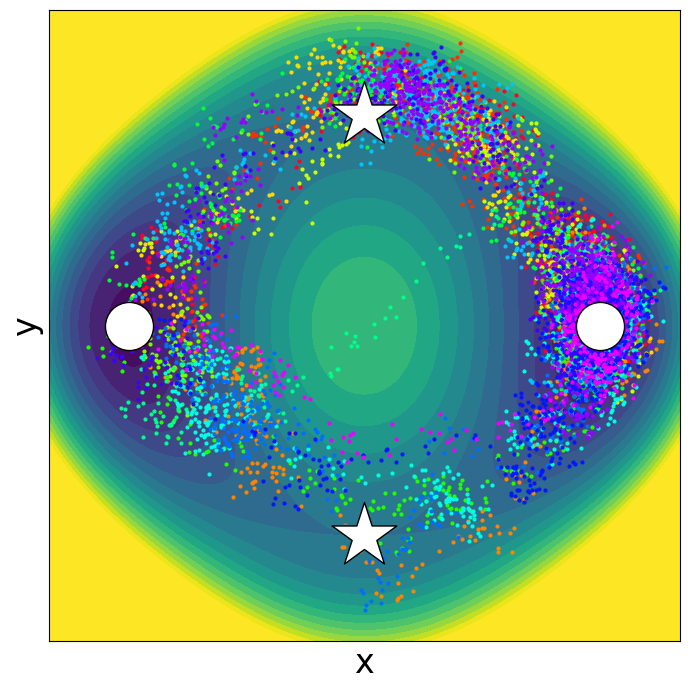

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.07it/s]


Rollout: 6, Loss: 0.000249
RMSD: 0.01±0.00 & THP: 100.00 & ETP: 1.66±0.29 & MinETP: 1.05 & EFP: -0.08±0.00 & LL: 2.97±0.07 & MaxLL: 3.19


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.49it/s]


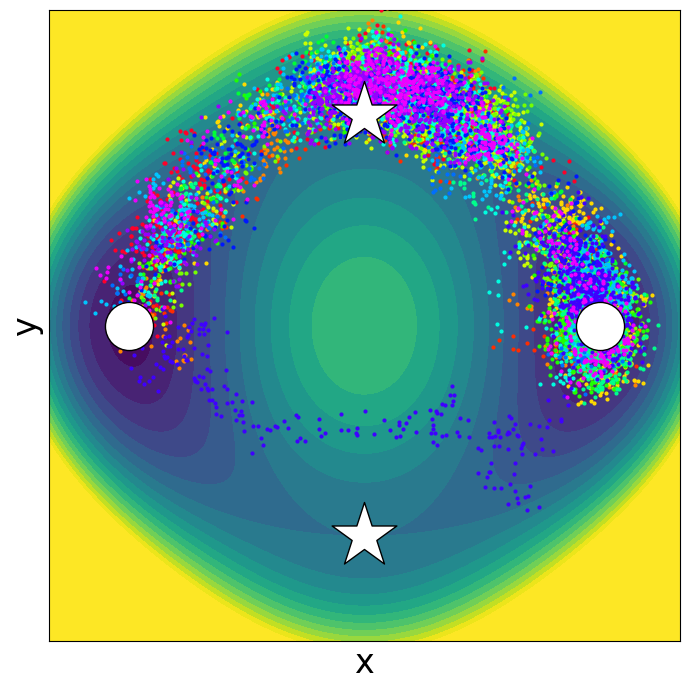

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.23it/s]


Rollout: 7, Loss: 0.000289
RMSD: 0.23±0.38 & THP: 75.39 & ETP: 1.97±0.31 & MinETP: 1.14 & EFP: -0.08±0.04 & LL: 3.06±0.05 & MaxLL: 3.22


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.20it/s]


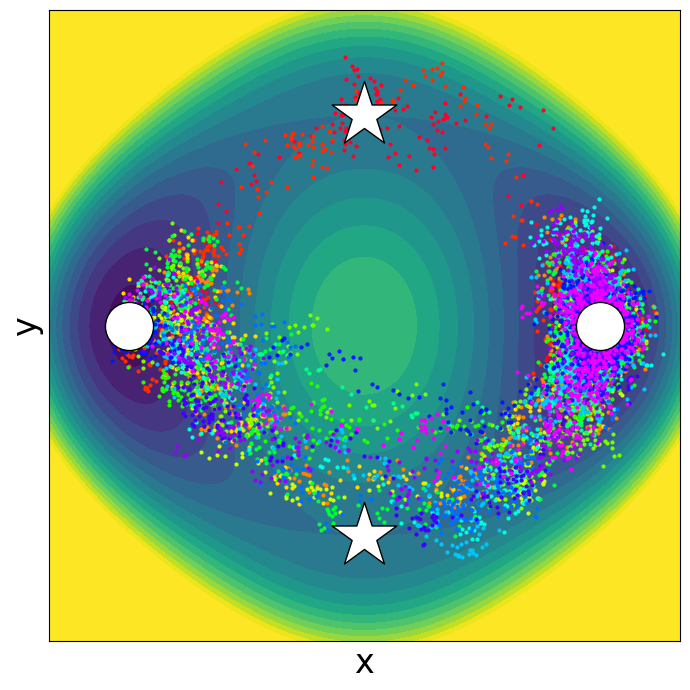

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.70it/s]


Rollout: 8, Loss: 0.000242
RMSD: 0.01±0.00 & THP: 100.00 & ETP: 1.49±0.24 & MinETP: 1.05 & EFP: -0.08±0.00 & LL: 3.19±0.06 & MaxLL: 3.34


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.14it/s]


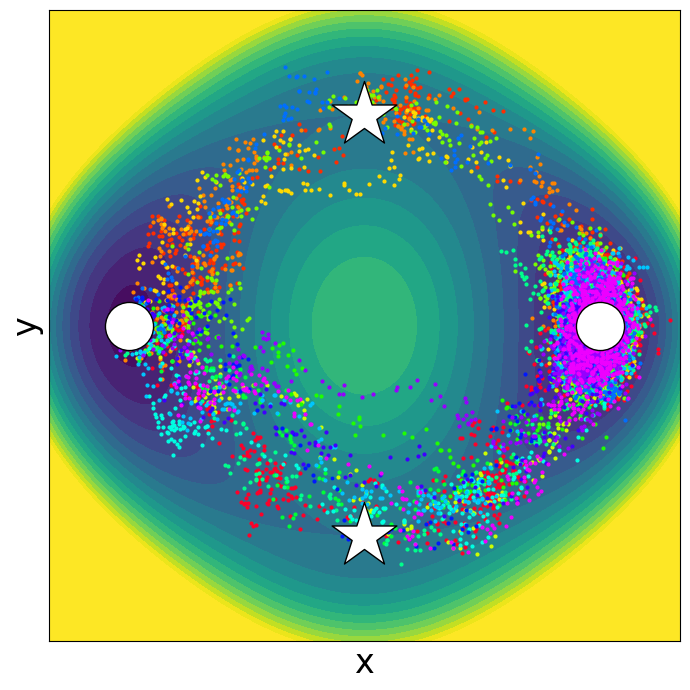

Training: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.80it/s]


Rollout: 9, Loss: 0.000210
RMSD: 0.01±0.00 & THP: 100.00 & ETP: 1.43±0.23 & MinETP: 1.06 & EFP: -0.08±0.00 & LL: 3.30±0.05 & MaxLL: 3.46


Sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.62it/s]


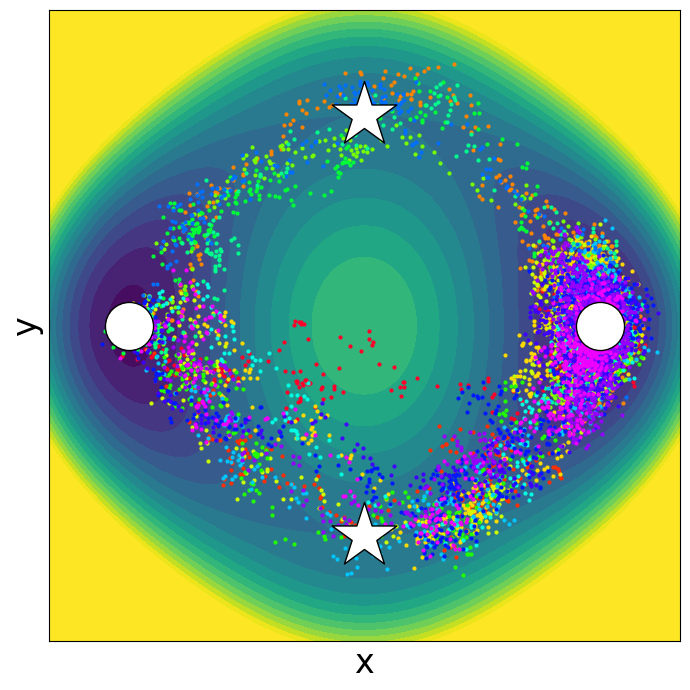

RMSD: 0.01±0.00 & THP: 100.00 & ETP: 1.39±0.22 & MinETP: 1.04 & EFP: -0.08±0.00 & LL: 3.31±0.05 & MaxLL: 3.46


In [10]:
torch.manual_seed(seed)

agent = FlowNetAgent()
metric = Metric()

for rollout in range(num_rollouts):
    data = agent.sample(stds[rollout])
    log = metric(*data)
    loss = agent.train()
    print(f"Rollout: {rollout}, Loss: {loss:.6f}")
    print_metric(log)

log = metric(*agent.sample(std))
print_metric(log)